In [1]:
from IPython.display import HTML

_Authors: Tyler Cochran, Pedro Lopes, Jonathan Wurtz, Arinjoy De, Kai Wu_

# Evaluating circuit-level performance under realistic noise

## Learning Objectives:
This lesson describes the effect of the noise sources on QuEra's Gemini-class quantum processors in detail, and aim at developing an in-depth intuition into the sources of noise on our Gemini-class machines. By the end of it, you will be able to:

* Compare the relative strengths of different noise channels on Gemini-class hardware
* Evaluate global vs local gate layer tradeoffs as a strategy to reduce errors.
* Evaluate the performance of different zoned architectures when deployed to a given quantum circuit.
* Manipulate the atom geometry to optimize circuit performance.

# Noise in Gemini-class digital neutral atom quantum processors

QuEra's Gemini-class processors are our first generation of digital quantum computers that take advantage of the unique capabilities of neutral-atom qubits. Gemini processors utilize arrays of neutral atoms trapped in optical tweezers, which can be dynamically rearranged to achieve arbitrary qubit connectivity (within a logarithmic number of moves). 

A main distinction between our analog and gate-based systems is how atomic energy levels are used for encoding information, and logic is deployed. On gate-based systems in the Gemini-class, the native gate set includes single-qubit rotations based on Raman transitions between atomic hyperfine states, while only two-qubit CZ entangling are gates based on excitations into Rydberg states for interaction. This allows for much longer coherence times and shuttling atoms without losing coherence, allowing for efficient implementation of quantum algorithms. As a first demonstration of our new hardware, we have recently [published a paper in Nature](https://www.nature.com/articles/s41586-025-09367-3) demonstration magic state distillation - a quantum error correction sub-routine - in the d=3 and d=5 color codes.

Like any quantum hardware, Gemini-class processors are subject to incoherent and coherent noise processes that cause errors in quantum circuits implemented on the device. To evaluate the practicality of implementing a task on the hardware, noise models at the circuit level can inform algorithm design. To this end, we have developed noise models using the popular circuit SDK [cirq](https://quantumai.google/cirq), which mains interoperability to our Bloqade-based circuit representation: [squin](https://bloqade.quera.com/latest/digital/cirq_interop/). The quantitative values of these error rates can be found in [bloqade](https://github.com/QuEraComputing/bloqade-circuit/blob/14fdf7aa9f0aa1e2476b230da9a9e7b4dc800231/src/bloqade/qasm2/dialects/noise/model.py#L5) and are described in what follows:

1. Global single qubit gate error
    - Depolarizing error applied to all qubits after a single qubit gate that is applied to all qubits in parallel.

<div align="center">
  <img src="./assets/global_single_qubit_gate_error.png" width="300">
</div>

1. Local single qubit gate error
    - Depolarizing error applied to gated single qubits after a single qubit gate that is applied to a subset of qubits.

<div align="center">
  <img src="./assets/local_single_qubit_gate_error.png" width="300">
</div>

1. CZ gate error
    - Pauli error channel that is biases towards phase errors applied to both qubits that are within the blockage radius during a Rydberg pulse.
    - Incorporates errors from the Rydberg pulse and dynamical decoupling.
1. Unpaired Rydberg error
    - Pauli error channel is biased towards phase errors applied to single qubits that experience a Rydberg pulse but do not have a partner qubit within the blockade radius.
    - Incorporates errors from the Rydberg pulse and dynamical decoupling.

<div align="center">
  <img src="./assets/rydberg_error.png" width="300">
</div>

1. Mover error
    - Pauli error channel that is also biased towards phase errors applied to qubits that must move during a circuit.
    - Incorporates errors from transferring atoms from fixed tweezer traps to dynamical traps for moves, dynamical decoupling, move errors, and idling errors.
1. Sitter error
    - Pauli error channel that is applied to atoms that are stationary while other atoms are moving.
    - Incorporates errors from dynamical decoupling and idling errors.

<div align="center">
  <img src="./assets/move_error.png" width="300">
</div>


The error rates are calculated by benchmarking results that will be published in a forthcoming paper characterizing the full performances of our Gemini-class hardware. 

Particularly relevant to our neutral atom platform is the implementation of atomic moves, required to situate atoms within the Rydberg blockade radius of each other for CZ gates. These atom moves are achieved using dynamic optical tweezers that impose certain [constraints on what moves can be executed concurrently](https://arxiv.org/abs/2506.05536v1). For a general quantum circuit, the optimization of these moves into the fewest possible steps is an active area of research and greatly effects the overall performance of the circuit, because the "sitter error" is significant, making it critical to reduce the total number of moves in a circuit to achieve high fidelity. 

In our [circuit noise models in bloqade](https://github.com/QuEraComputing/bloqade-circuit/blob/main/src/bloqade/cirq_utils/noise/model.py), we have taken a middle ground estimate to the number of move steps that are required for a general circuit. For circuits that are amenable to highly parallelized moves when the atom geometry is suitably chosen, our noise models will likely overestimate the total error. However, for worst case circuits that require many move steps for a given circuit layer, our noise models may underestimate the total error. Therefore, a realistic range of performance can be achieved by scaling the mover and sitting error rates.

# One zone and two zone noise models

Looking at the hardware more in-depth, there are a couple of options for how to architect the geometry with respect to the entangling zone (ie. the area of the chamber where the Rydberg laser is applied) and the rest of the space accessible by the dynamic tweezers. In the "One Zone" scheme, all the qubits live within the entangling zone for the duration of the experiment. This scheme often can minimize move errors, but all qubits also are exposed to the Rydberg beam, so unpaired errors are significant. In the "Two Zone" scheme, qubits can be shuttled between a storage zone where the Rydberg beam is not applied and the entangling zone. This scheme can minimize unpaired errors, but often requires more moves, which can increase the sitter and mover errors. The choice between these two schemes is often a trade-off that depends on the structure of the circuit.

In our one-zone model, we make the assumption that all qubits can move to their entangling partners in a single move step. However, we only need to move one qubit to its gate partner, while the other stays fixed. Then after the gate, the qubit that moved goes back to its original position. This is a rather simplistic assumption and, while not generally the best choice, it may work well for certain circuits.



In [4]:
from IPython.display import Video
Video("./assets/GHZ1Zone.mp4", embed=True, width=520)

In our two-zone model, we instead make the assumption that if a qubit does not participate in a gate, it should be moved to the storage zone. As discussed, in some cases, this may result in less total error during the circuit. The model also accounts for moves associated with pairing up qubits within the entangling zone for the CZ gates. Again, this model is rather simplistic and can lead to qubits frequently moving between zones, with detrimental consequences to the total circuit fidelity.



In [5]:
Video("./assets/GHZ2Zone.mp4", embed=True, width=520)

The implementation of these models is well described in the [bloqade documentation](https://bloqade.quera.com/v0.27.1/digital/examples/noisy_ghz/). One point perhaps worthy of noting is that in Bloqade's two-zone model, qubits must be in the entanglement zone to receive any local gate.

Finally, an important disclaimer is that these noise models exclusively use Pauli channels, modeling incoherent errors. Coherent errors and leakage/loss events are not explicitly accounted for, but rather folded into the effective Pauli error rates. This is a reasonable approximation for many use cases, but may not be valid for all circuits.

# Global vs local single qubit gates

In [2]:
import cirq
import matplotlib.pyplot as plt
import qsimcirq
import numpy as np
import warnings

from bloqade.cirq_utils.noise import (
    transform_circuit,
    GeminiOneZoneNoiseModel,
    GeminiTwoZoneNoiseModel,
)

simulator = qsimcirq.QSimSimulator()

/Users/Plopes/Documents/Github/quera-education/.venv/lib/python3.13/site-packages/qpsolvers/solvers/__init__.py:880: UserWarning: no QP solver found on your system, you can install solvers from PyPI by ``pip install qpsolvers[open_source_solvers]``
  warnings.warn(


Let's suppose we want to test the very basic circuit shown below.

In [7]:
q0, q1 = cirq.LineQubit.range(2)

cirq.Circuit.from_moments(
    cirq.Moment(cirq.X(q0), cirq.Y(q1)),
    cirq.Moment(cirq.Y(q0), cirq.X(q1)),
    cirq.Moment(cirq.X(q0), cirq.Y(q1)),
    cirq.Moment(cirq.Y(q0), cirq.X(q1)),
)

0: ───X───Y───X───Y───

1: ───Y───X───Y───X───

This circuit does not have any two qubit gates, so we don't have to worry about any complications due to moves between operations. However, we do have to think carefully about the effects of global vs local single qubit gates. In the above circuit, all of the gates must be applied locally, because the X and Y gates are applied to different qubits in the same moment. However, the errors associated with local single qubit gates are almost an order of magnitude higher, compared to _global_ single qubit gates.

In this case, we can increase the number of gate layers by one to make all the gates global by sliding the gates on qubit 0 back one moment:

In [8]:
cirq.Circuit.from_moments(
    cirq.Moment(cirq.Y(q1)),
    cirq.Moment(cirq.X(q0), cirq.X(q1)),
    cirq.Moment(cirq.Y(q0), cirq.Y(q1)),
    cirq.Moment(cirq.X(q0), cirq.X(q1)),
    cirq.Moment(cirq.Y(q0))
)

0: ───────X───Y───X───Y───

1: ───Y───X───Y───X───────

Let's see how the noise model handles these two circuits.

First, we will rewrite the `cirq.X` and `cirq.Y` gates in terms of `cirq.PhasedXZGate`s. In most cases, this step is not necessary because the `transform_circuit` function, which adds noise moments to the circuit, will decompose arbitrary single qubit gates into the native gate set. However, this transformer also combines subsequent single qubit gates on the same qubit into a single gate, which would render both circuits above trivial. Therefore, we will manually write the circuits in terms of `cirq.PhasedXZGate`s and set `to_native_gateset=False` in the `transform_circuit` function.

In [9]:
XGATE = cirq.PhasedXZGate(x_exponent = 1,  z_exponent = 0, axis_phase_exponent = 0)
YGATE = cirq.PhasedXZGate(x_exponent = 1,  z_exponent = 0, axis_phase_exponent = 0.5)

In [10]:
def pi_blocks(q0: cirq.Qid, q1: cirq.Qid, n: int, global_gates: bool = True) -> list[cirq.Moment]:
    if global_gates is True:
        return [cirq.Moment(YGATE.on(q1))] + [
            cirq.Moment(XGATE.on_each([q0, q1])),
            cirq.Moment(YGATE.on_each([q0, q1])),
            ] * (n - 1) + [cirq.Moment(XGATE.on_each([q0, q1])),
                           cirq.Moment(YGATE.on(q0))]
    else:
        return [
            cirq.Moment(XGATE.on(q0), YGATE.on(q1)),
            cirq.Moment(YGATE.on(q0), XGATE.on(q1)),
        ] * n

Let's set `global_gates=False` and inspect the noisy circuit. We'll start by picking the GeminiTwoZoneNoiseModel.

In [11]:
local_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, 2,global_gates=False))
print('The clean circuit with local gates:')
print(local_circuit)

The clean circuit with local gates:
0: ───PhXZ(a=0,x=1,z=0)─────PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────PhXZ(a=0.5,x=1,z=0)───

1: ───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────


In [12]:
model = GeminiTwoZoneNoiseModel()
local_circuit_noisy = transform_circuit(local_circuit,to_native_gateset=False, model = model)
print('The noisy circuit with local gates:')
print(local_circuit_noisy)

The noisy circuit with local gates:
0: ───A(0.000806,0.000806,0.00246)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───

1: ───A(0.000806,0.000806,0.00246)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───


Let's unpack this noise annotated circuit a bit, moment by moment:

1. The error coming from moving the qubits from the storage zone into the entangling zone.
1. The ideally implemented local single qubit gates.
1. The depolarizing error associated with local single qubit gates (note that `px = py = pz`).
1. The the ideal single qubit gates
1. The associated error.

and so on...

Now's let's compare this to the case where we slide the top gates back by one moment to make some of the gates global:

In [13]:
global_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, 2,global_gates=True))
print('The clean circuit with global gates:')
print(global_circuit)

The clean circuit with global gates:
0: ─────────────────────────PhXZ(a=0,x=1,z=0)───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)───PhXZ(a=0.5,x=1,z=0)───

1: ───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────────────────────────


___
## Activity: predicting noise channel annotation

Based on your experience above, draw for yourself the expected error annotation for this new circuit before running the next cell.
___

In [14]:
global_circuit_noisy = transform_circuit(global_circuit,to_native_gateset=False, model = model)
print('The noisy circuit with a global gate:')
print(global_circuit_noisy)

The noisy circuit with a global gate:
0: ───A(0.000307,0.000307,0.000464)───────────────────────────────────────────────────────A(0.000806,0.000806,0.00246)────PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0.5,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───A(0.000307,0.000307,0.000464)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───

1: ───A(0.000806,0.000806,0.00246)────PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───A(0.000307,0.000307,0.000464)───PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0.5,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───A(0.000806,0.000806,0.00246)────────────────────────────────────────────────────────


Stepping through this circuit moment by moment:

1. The move error on qubit 1 to go from the storage zone into the entangling zone, qubit 0 gets the sitter error.
1. The ideal local gate on qubit 1.
1. The local single qubit error on qubit1.
1. The Pauli error channel associated with qubit 0 moving into the entangling zone from the storage zone and qubit 1 sitting while qubit 0 moves.
1. The global X gate on both qubits.
1. The depolarizing error from the global X gate, which is much smaller than the local gate error.
1. The global Y gate on both qubits.
1. The associated depolarizing error.
1. The 2nd global X gate.
1. The associated depolarizing error.
1. The move error to return qubit 1 to the storage zone, qubit 0 sees the sitter error.
1. The local Y gate on qubit 0.
1. The error associated with the local Y gate on qubit 0.

Now, we can simulate both circuits and even compare the behavior as we increase the number of times the pattern is repeated. Let's choose the following depths:

In [15]:
number_of_blocks = np.linspace(2,100,10).astype(int)
print('List of number of blocks to simulate:')
print(number_of_blocks)

List of number of blocks to simulate:
[  2  12  23  34  45  56  67  78  89 100]


Simulating the different circuits and compare the probability of measuring the $|0\rangle$ state as a function of depth, we have

In [16]:
global_state_histograms = {}
local_state_histograms = {}
reps = 1000
for depth in number_of_blocks:
    local_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, depth, global_gates=False))
    global_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, depth, global_gates=True))

    local_circuit_noisy = transform_circuit(local_circuit,to_native_gateset=False, model = model)
    global_circuit_noisy = transform_circuit(global_circuit,to_native_gateset=False, model = model)

    global_results = simulator.run(global_circuit_noisy + cirq.measure([q0, q1], key='m'), repetitions=reps)
    local_results = simulator.run(local_circuit_noisy + cirq.measure([q0, q1], key='m'), repetitions=reps)

    global_state_histograms[depth] = global_results.histogram(key='m')
    local_state_histograms[depth] = local_results.histogram(key='m')


We can plot the fidelity of the state (ie. the probability of measuring the $|00\rangle$ state).

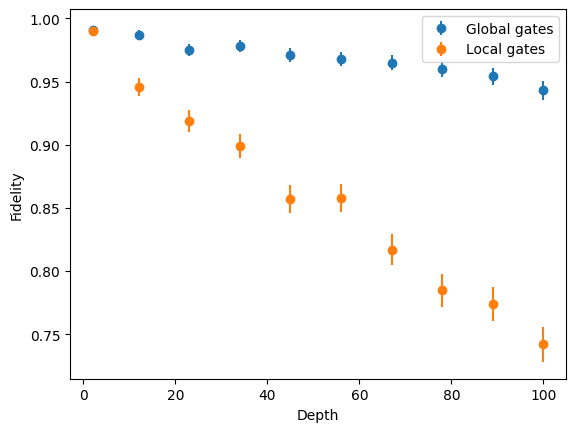

In [17]:
global_00_prob = np.array([hist[0] / reps for hist in global_state_histograms.values()])
local_00_prob = np.array([hist[0] / reps for hist in local_state_histograms.values()])

global_00_err = np.sqrt(global_00_prob * (1 - global_00_prob) / reps)
local_00_err = np.sqrt(local_00_prob * (1 - local_00_prob) / reps)

plt.errorbar(number_of_blocks, global_00_prob, yerr=global_00_err, linestyle='', marker='o', label='Global gates')
plt.errorbar(number_of_blocks, local_00_prob, yerr=local_00_err, linestyle='', marker='o', label='Local gates')

plt.ylabel('Fidelity')
plt.xlabel('Depth')
plt.legend()
plt.show()

We can see as the circuit depth increases, the circuit with more global gates outperforms the circuit with all local gates. Accordingly, when structuring quantum circuits for Gemini-class processors, one should always look for opportunities to increase the number of global gates, often even if at the expense of increasing the circuit depth

___
## Exercise

Let's learn how to analyze a circuit instance where adding a global gate layer into a circuit can reduce errors on Gemini-class hardware.

There is a system of $N$ qubits. In a moment of the circuit, $x$ of them need a $\sqrt{Y}$ gate, while the other $N-x$ need a $\sqrt{Y}^{\dagger}$ gate. What is the best way to structure the circuit to minimize the total error, given a global error $\epsilon_g$ which is applied to all $N$ qubits during a global gate and a local error $\epsilon_l$ that is only applied to the atoms to which the local gate is applied? Assume $\epsilon_g < \epsilon_l$ and $x$ can take any value between $0$ and $N$.
___

# One Zone vs Two Zone Model

Now let's shift our focus to a circuit that has also CZ gates and therefore requires atom moves. A canonical example of such a circuit is the GHZ state prepared in log(N) depth. We here repeat some of the treatment in the [bloqade documentation](https://bloqade.quera.com/v0.27.1/digital/examples/noisy_ghz/).

Let's compare the behavior of the one-zone and two-zone noise models, but first we need to define the GHZ circuit in log(N) depth:

In [19]:
def ghz_log_depth_circuit(n_qubits: int) -> cirq.Circuit:
    qubits = cirq.LineQubit.range(n_qubits)
    circuit = cirq.Circuit()

    # Step 1: Start with a Hadamard on the first qubit
    circuit.append(cirq.H(qubits[0]))

    # Step 2: Apply CNOTs in log-depth tree structure
    targeted = 1
    while targeted < n_qubits:
        moment = cirq.Moment()
        for i in range(0, targeted):
            if targeted+i <n_qubits:
                moment += cirq.CNOT(qubits[i], qubits[targeted+i])
            else:
                break
        targeted += targeted
        circuit += moment

    return circuit

Now, transforming the ideal GHZ circuit using both the one zone and two zone noise models, we can simulate the separate models. In this case, we'll track the fidelity of the final density matrix with respect to the ideal density matrix as we increase the number of qubits.

In [20]:
qubits = range(3, 11)

one_zone_model = GeminiOneZoneNoiseModel()
two_zone_model = GeminiTwoZoneNoiseModel()
simulator = cirq.DensityMatrixSimulator()

fidelities_one_zone = []
fidelities_two_zone = []
for n in qubits:
    circuit = ghz_log_depth_circuit(n)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        one_zone_circuit = transform_circuit(circuit, model=one_zone_model)
        two_zone_circuit = transform_circuit(circuit, model=two_zone_model)

        rho = simulator.simulate(circuit).final_density_matrix
        rho_one_zone = simulator.simulate(one_zone_circuit).final_density_matrix
        rho_two_zone = simulator.simulate(two_zone_circuit).final_density_matrix

        fidelity_one_zone = np.trace(rho @ rho_one_zone)
        fidelity_two_zone = np.trace(rho @ rho_two_zone)

        fidelities_one_zone.append(np.real(fidelity_one_zone))
        fidelities_two_zone.append(np.real(fidelity_two_zone))

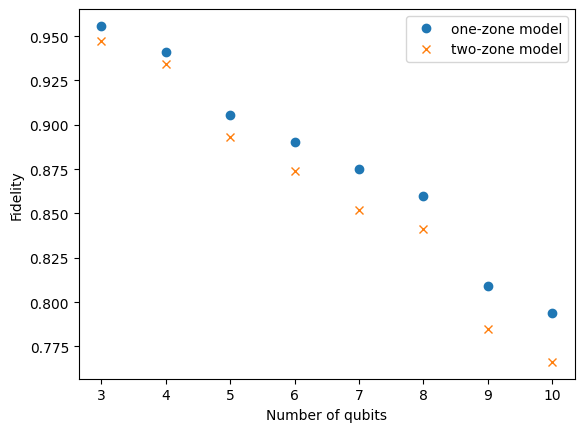

In [21]:
plt.plot(qubits, fidelities_one_zone, "o", label="one-zone model")
plt.plot(qubits, fidelities_two_zone, "x", label="two-zone model")
plt.xlabel("Number of qubits")
plt.ylabel("Fidelity")
plt.legend()
plt.show()

We see that for this circuit, the one zone model performs better than the two zone model. What is more, we observe jumps in the fidelity after 4 and 8 qubits, corresponding to the addition of an extra entangling layer in the log(N) depth circuit. However, the difference between the two models grows with the number of CZ gates, not the number of layers. This stems from the extra moves that occur in the two zone model.

___
## Exercise

Below is a potential benchmarking circuit that amplifies coherent Z errors on the system qubits q1 and q2. By means of a Hadamard test, we measure $\langle X(t) X(0) \rangle$. By repeating CZ gates on the system qubits, while manually inserting a coherent phase rotation to mimic a systematic phase error, we can see the effect of coherent errors on the circuit performance.

In [22]:
import cirq
from bloqade.cirq_utils.noise import transform_circuit, GeminiTwoZoneNoiseModel
dsim = cirq.DensityMatrixSimulator()

q0,q1,q2 = cirq.LineQubit.range(3)

coherent_rotation_angle = 0.05

def create_ztz0_circuit(depth:int) -> cirq.Circuit:
    moments = [
        #initialize q0 in |+> and do a CNOT to q1.
        cirq.Moment(cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=-0.5, z_exponent=0.0).on_each(q0,q1)),
        cirq.Moment(cirq.CZ(q0,q1)),
        cirq.Moment(cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(q1)),
        #manually add coherent error for each CZ gate
        *[cirq.Moment(cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=coherent_rotation_angle).on_each(q1,q2)), cirq.Moment(cirq.CZ(q1,q2))]*depth,
        #finish the hadamard test
        cirq.Moment(cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=-0.5, z_exponent=0.0).on(q1)),
        cirq.Moment(cirq.CZ(q0,q1)),
        cirq.Moment(cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(q0))
    ]

    return cirq.Circuit.from_moments(*moments)

print(create_ztz0_circuit(3))

0: ───PhXZ(a=-0.5,x=-0.5,z=0)───@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@───PhXZ(a=0.5,x=0.5,z=0)───
                                │                                                                                                                                      │
1: ───PhXZ(a=-0.5,x=-0.5,z=0)───@───PhXZ(a=0.5,x=0.5,z=0)───PhXZ(a=0,x=0,z=0.05)───@───PhXZ(a=0,x=0,z=0.05)───@───PhXZ(a=0,x=0,z=0.05)───@───PhXZ(a=-0.5,x=-0.5,z=0)───@───────────────────────────
                                                                                   │                          │                          │
2: ─────────────────────────────────────────────────────────PhXZ(a=0,x=0,z=0.05)───@───PhXZ(a=0,x=0,z=0.05)───@───PhXZ(a=0,x=0,z=0.05)───@─────────────────────────────────────────────────────────


Let's plot the results for many depths

Text(0, 0.5, '$\\langle X(t) X(0) \\rangle$')

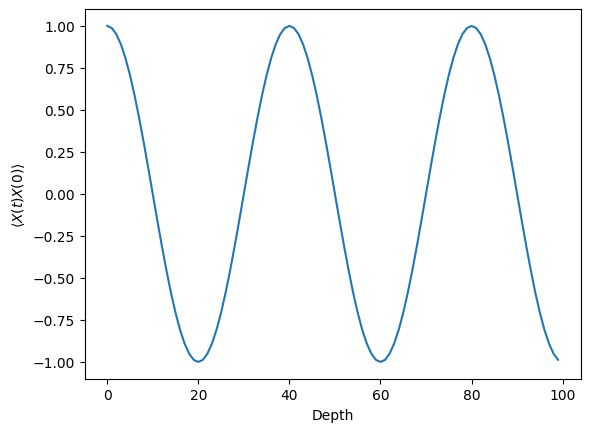

In [23]:
res = []
for depth in range(100):
    circuit = create_ztz0_circuit(depth)
    res.append(np.real(cirq.Simulator().simulate_expectation_values(circuit,observables = [cirq.Z(q0)])))

plt.plot(res)
plt.xlabel('Depth')
plt.ylabel("$\\langle X(t) X(0) \\rangle$")


Can you predict the behavior of this circuit under the one zone and two zone models? Why might one model be better than the other? Pass the circuit through both models and simulate the results.

___

# Exploring circuit geometry with GridQubits

So, we've written some circuits, benchmarked them using the `GeminiOneZoneNoiseModel` and `GeminiTwoZoneNoiseModel`. Now we're ready to start thinking about the geometry of the atoms in the hardware. Our circuit-level noise modelling tools provide a bridge to the world of move compilation via the `GeminiOneZoneNoiseModelConflictGraphMoves` noise model. This model uses the same noise parameters as the `GeminiOneZoneNoiseModel`, but also estimates the number of required moves to satisfy the dynamical tweezer constrains using a conflict graph approach. This approach can provide a more realistic estimate of the circuit fidelity and help optimize the experimental geometry of the qubits relative to the circuit. 

Ultimately, the `Bloqade-shuttle` dialect will be the tool to control atom shuttling schedules. But fo the sake of an easy-to-access tool for estimations, playing with `GeminiOneZoneNoiseModelConflictGraphMoves` can carry us a long way. So let's practice using it using the example of the nine-qubit GHZ state prepared in log(N) depth.

In [25]:
line_qubit_circuit = ghz_log_depth_circuit(9)
print(line_qubit_circuit)

              ┌──┐   ┌────┐
0: ───H───@────@──────@───────@───
          │    │      │       │
1: ───────X────┼@─────┼@──────┼───
               ││     ││      │
2: ────────────X┼─────┼┼@─────┼───
                │     │││     │
3: ─────────────X─────┼┼┼@────┼───
                      ││││    │
4: ───────────────────X┼┼┼────┼───
                       │││    │
5: ────────────────────X┼┼────┼───
                        ││    │
6: ─────────────────────X┼────┼───
                         │    │
7: ──────────────────────X────┼───
                              │
8: ───────────────────────────X───
              └──┘   └────┘


Now, let's map the `cirq.LineQubit`s to `cirq.GridQubit`s to define the geometry. By mapping to different geometries, we will see a different number of total moments in the output circuit, corresponding to some geometries requiring more moves to arrange the atoms without violating the dynamical tweezer constraints.

In [26]:
from bloqade.cirq_utils.noise import GeminiOneZoneNoiseModelConflictGraphMoves

In [27]:
map1 = {
    cirq.LineQubit(0): cirq.GridQubit(0, 0),
    cirq.LineQubit(1): cirq.GridQubit(0, 1),
    cirq.LineQubit(2): cirq.GridQubit(0, 2),
    cirq.LineQubit(3): cirq.GridQubit(1, 0),
    cirq.LineQubit(4): cirq.GridQubit(1, 1),
    cirq.LineQubit(5): cirq.GridQubit(1, 2),
    cirq.LineQubit(6): cirq.GridQubit(2, 0),
    cirq.LineQubit(7): cirq.GridQubit(2, 1),
    cirq.LineQubit(8): cirq.GridQubit(2, 2),
}

geometry1 = line_qubit_circuit.transform_qubits(lambda q: map1[q])
print(geometry1)

                   ┌──┐   ┌────┐
(0, 0): ───H───@────@──────@───────@───
               │    │      │       │
(0, 1): ───────X────┼@─────┼@──────┼───
                    ││     ││      │
(0, 2): ────────────X┼─────┼┼@─────┼───
                     │     │││     │
(1, 0): ─────────────X─────┼┼┼@────┼───
                           ││││    │
(1, 1): ───────────────────X┼┼┼────┼───
                            │││    │
(1, 2): ────────────────────X┼┼────┼───
                             ││    │
(2, 0): ─────────────────────X┼────┼───
                              │    │
(2, 1): ──────────────────────X────┼───
                                   │
(2, 2): ───────────────────────────X───
                   └──┘   └────┘


In [28]:
map2 = {
    cirq.LineQubit(0): cirq.GridQubit(0, 0),
    cirq.LineQubit(1): cirq.GridQubit(0, 1),
    cirq.LineQubit(2): cirq.GridQubit(0, 2),
    cirq.LineQubit(3): cirq.GridQubit(0, 3),
    cirq.LineQubit(4): cirq.GridQubit(1, 0),
    cirq.LineQubit(5): cirq.GridQubit(1, 1),
    cirq.LineQubit(6): cirq.GridQubit(1, 2),
    cirq.LineQubit(7): cirq.GridQubit(1, 3),
    cirq.LineQubit(8): cirq.GridQubit(2, 0),
}

geometry2 = line_qubit_circuit.transform_qubits(lambda q: map2[q])
print(geometry2)

                   ┌──┐   ┌────┐
(0, 0): ───H───@────@──────@───────@───
               │    │      │       │
(0, 1): ───────X────┼@─────┼@──────┼───
                    ││     ││      │
(0, 2): ────────────X┼─────┼┼@─────┼───
                     │     │││     │
(0, 3): ─────────────X─────┼┼┼@────┼───
                           ││││    │
(1, 0): ───────────────────X┼┼┼────┼───
                            │││    │
(1, 1): ────────────────────X┼┼────┼───
                             ││    │
(1, 2): ─────────────────────X┼────┼───
                              │    │
(1, 3): ──────────────────────X────┼───
                                   │
(2, 0): ───────────────────────────X───
                   └──┘   └────┘


Now let's compare the circuits using these two geometries after passing through the noise model.

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = GeminiOneZoneNoiseModelConflictGraphMoves()
    circuit1_noisy = transform_circuit(geometry1, model=model)
    print(f'geometry1 required {len(circuit1_noisy)} total moments')

geometry1 required 30 total moments


This geometry has move conflicts:

<div align="center">
  <img src="./assets/geometry1_moves.png" width="300">
</div>


In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = GeminiOneZoneNoiseModelConflictGraphMoves()
    circuit2_noisy = transform_circuit(geometry2, model=model)
    print(f'Geometry two required {len(circuit2_noisy)} total moments')

Geometry two required 28 total moments


In contrast, this does not have any move conflicts:

<div align="center">
  <img src="./assets/geometry2_moves.png" width="300">
</div>


___
## Activity: exploring geometries

In this activity you will learn to manipulate geometries to optimize circuit performance for arbitrary circuits. As we have learned so far, it all boils down to parallelization. So let's try to define geometries and use the conflic graph model for atom shuttling coordination to optimize for parallelizability.

Cirq allows from mapping a circuit from on set of qubits to another, as shown below:

In [31]:
import cirq
dsim = cirq.DensityMatrixSimulator()
from bloqade.cirq_utils.noise import transform_circuit, GeminiOneZoneNoiseModelConflictGraphMoves
import numpy as np

random_circuit_seed = 42

qreg = cirq.LineQubit.range(4)
input_circuit = cirq.testing.random_circuit(qubits=qreg,n_moments = 10, op_density=1, random_state=random_circuit_seed)
input_circuit
#%%
map1 = {
    cirq.LineQubit(0): cirq.GridQubit(0, 0),
    cirq.LineQubit(1): cirq.GridQubit(0, 1),
    cirq.LineQubit(2): cirq.GridQubit(0, 2),
    cirq.LineQubit(3): cirq.GridQubit(0, 3),
}

map2 = {
    ...
}

Now fill in map2 above with the mapping that minimizes the number of moves, and thus maximizes the fidelity. Confirm that the fidelity is indeed higher with the following script. After that, try different input circuits by changing the random seed and/or increasing the number of qubits. Feel free to use the fidelity estimators below to study performance variations

In [ ]:
noiseless_rho = dsim.simulate(input_circuit).final_density_matrix
noisy1_rho = dsim.simulate(transform_circuit(input_circuit.transform_qubits(lambda q: map1[q]), model=GeminiOneZoneNoiseModelConflictGraphMoves())).final_density_matrix
noisy2_rho = dsim.simulate(transform_circuit(input_circuit.transform_qubits(lambda q: map2[q]), model=GeminiOneZoneNoiseModelConflictGraphMoves())).final_density_matrix
fid1 = np.trace(noiseless_rho @ noisy1_rho)
fid2 = np.trace(noiseless_rho @ noisy2_rho)

___

# Conclusions

That is a wrap! Welcome to the realm of co-designing algorithms for neutral-atom quantum computers!

By following this lesson, no you are be able to:

* Compare the relative strengths of different noise channels on Gemini-class hardware
* Evaluate global vs local gate layer tradeoffs as a strategy to reduce errors.
* Evaluate the performance of different zoned architectures when deployed to a given quantum circuit.
* Manipulate the atom geometry to optimize circuit performance.

Stay tuned for next advances and topics!